In [1]:
!nvidia-smi

In [2]:
!pip freeze | grep keras
!pip freeze | grep Keras
!pip freeze | grep tensorflow
!pip freeze | grep h5py
!pip freeze | grep opencv 
!pip freeze | grep pandas

keras==2.7.0
keras-segmentation==0.3.0
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.2
tensorflow==2.7.0
tensorflow-estimator==2.7.0
tensorflow-io-gcs-filesystem==0.21.0
h5py==2.10.0
opencv-python==4.5.5.62
pandas==1.3.5


In [3]:
# !pip install q tensorflow==2.1
# !pip install q keras==2.3.1
# !pip install git+https://github.com/qubvel/segmentation_models

# for str decode error ... run it and restart runtime
# !pip uninstall h5py -y
!pip install h5py==2.10.0

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
i = !ls Dataset/IDD/images/
l = !ls Dataset/IDD/masks/
len(i), len(l)

(5966, 5966)

In [6]:
l[-5:], i[-5:]

(['frame9980.png',
  'frame9982.png',
  'frame9991.png',
  'frame9994.png',
  'frame99992.png'],
 ['frame9980.jpg',
  'frame9982.jpg',
  'frame9991.jpg',
  'frame9994.jpg',
  'frame99992.jpg'])

In [7]:
import cv2
from glob import glob
import os
import numpy as np

# 100 = background
# 101 = road
# 102 = obstacle(person, rider, car, truck, bus, train, motorcycle, bicycle)

l = glob('Dataset/IDD/masks/*')
m = cv2.imread(l[2970],0)
m.shape
np.unique(m)


array([0, 1, 2], dtype=uint8)

In [8]:
import os
len(os.listdir('Dataset/IDD/Test/images/')), len(os.listdir('Dataset/IDD/masks/'))

(1016, 5966)

In [9]:
import numpy as np
import cv2
import os
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_dataset(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))

    train_x, test_x, train_y, test_y = train_test_split(images,masks, test_size=0.1702, 
                                                        random_state=168, shuffle=True)
    return train_x, train_y, test_x, test_y

train_x, train_y, val_x, val_y = load_dataset('Dataset/IDD')
print(len(train_x), len(train_y), len(val_x), len(val_y))

4950 4950 1016 1016


### TF data API

In [10]:
train_X_y_paths = list(zip(train_x, train_y))
val_X_y_paths = list(zip(val_x, val_y))

In [11]:
IMG_SIZE = 512
def parse_x_y(img_path,mask_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    
    mask = tf.io.read_file(mask_path)    
    mask = tf.image.decode_png(mask, channels=1)  
    return {'image': image, 'segmentation_mask': mask}

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE),method='nearest')    
#     if tf.random.uniform(()) > 0.5:
#         input_image = tf.image.flip_left_right(input_image)
#         input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    input_mask = tf.one_hot(input_mask, 3)
    input_mask = tf.reshape(input_mask, (IMG_SIZE, IMG_SIZE, 3))
    return input_image, input_mask

AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 42
BATCH_SIZE = 4
BUFFER_SIZE = 2*BATCH_SIZE

train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset = train_dataset.map(parse_x_y)

val_dataset = tf.data.Dataset.from_tensor_slices((val_x,val_y))
val_dataset =val_dataset.map(parse_x_y)

dataset = {"train": train_dataset, "val": val_dataset}

dataset['train'] = dataset['train'].map(
    load_image_train,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
).shuffle(buffer_size=BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

dataset['val'] = dataset['val'].map(
    load_image_train, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
).shuffle(buffer_size=BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [12]:
for image,label in dataset['train'].take(1):
    print("Train image: ",image.shape)
    print("Train label: ",label.shape,"\n\tunique values", np.unique(label[0]))
    
for image,label in dataset['val'].take(1):
    print("Val image: ",image.shape)
    print("Val label: ",label.shape,"\n\tunique values", np.unique(label[0]))

Train image:  (4, 512, 512, 3)
Train label:  (4, 512, 512, 3) 
	unique values [0. 1.]
Val image:  (4, 512, 512, 3)
Val label:  (4, 512, 512, 3) 
	unique values [0. 1.]


In [13]:
import matplotlib.pyplot as plt

def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(7, 7))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


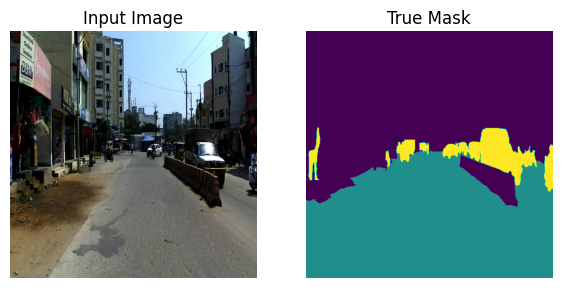

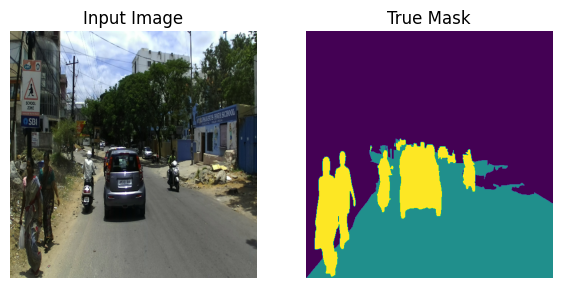

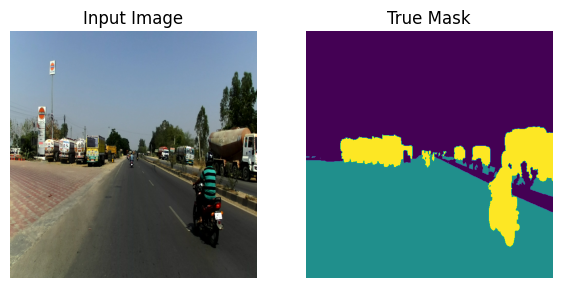

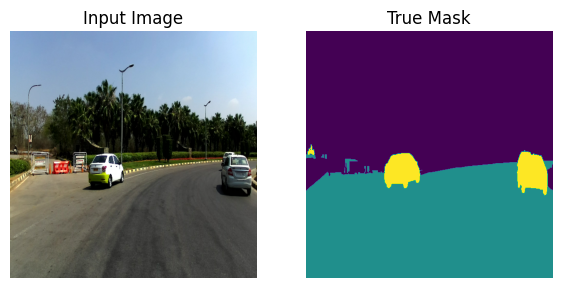

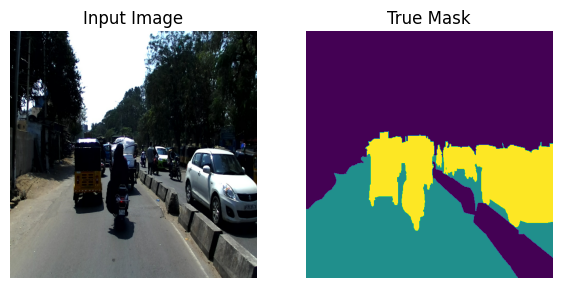

In [14]:
i=0
for image, mask in dataset['train'].take(5):
    i=i+1
#     print(i)
    sample_image, sample_mask = image, mask
    t = np.argmax(sample_mask[0],axis=-1)
    t = tf.expand_dims(t,axis=-1)
    display_sample([sample_image[0],t])

In [16]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [17]:
# !pip install keras-segmentation

In [18]:
from segmentation_models import Unet, PSPNet, Linknet, FPN
from segmentation_models.utils import set_trainable
# model = Unet('mobilenetv2',input_shape=[512,512,3], classes=3, activation='softmax', encoder_freeze=True,
#              encoder_weights="pretrained_weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5")
# model = PSPNet('mobilenetv2',input_shape=[528,528,3], classes=3, activation='softmax', encoder_freeze=True,
#              encoder_weights="pretrained_weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5")
# model = Linknet('mobilenetv2',input_shape=[512,512,3], classes=3, activation='softmax', encoder_freeze=True,
#              encoder_weights="pretrained_weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5")
model = FPN('mobilenetv2',input_shape=[512,512,3], classes=3, activation='softmax', encoder_freeze=True,
             encoder_weights="pretrained_weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5")

# ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 
#  'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152',
#  'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101',
#  'vgg16', 'vgg19', 
#  'densenet121', 'densenet169', 'densenet201', 
#  'inceptionresnetv2', 'inceptionv3',
# 'mobilenet', 'mobilenetv2', 
# 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']

Segmentation Models: using `tf.keras` framework.


In [19]:
# from tensorflow.keras.applications import MobileNetV2
# encoder = MobileNetV2(input_shape=[512,512,3], weights="pretrained_weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_224_no_top.h5", include_top=False, alpha=0.35)
# # encoder.load_weights("pretrained_weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_224_no_top.h5")

In [20]:
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
ls = dice_loss + cce_jaccard_loss
metrics = [precision, recall, f1_score, iou_score] 

# from tensorflow.keras.models import load_model
# model = load_model('IDD_mobilenetV2_edge/ckpt_path/350.h5',
#                    custom_objects={'dice_loss_plus_categorical_crossentropy_plus_jaccard_loss':ls,
#                                    'precision':precision, 'recall':recall, 'f1-score':f1_score, 'iou_score':iou_score})

In [25]:
import os, time, keras
%env SM_FRAMEWORK=tf.keras

import numpy as np
import tensorflow as tf
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

""" Hyperparamaters """
BATCH_SIZE = 4
epochs = 1000
base_dir = 'RESULTS/IDD_FPN_mobilenetV2_alpha1.0_bs8'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    os.mkdir(f"{base_dir}/ckpt_path")
    
csv_path = f"{base_dir}/history.csv"

""" callbacks """
root_logdir = os.path.join(os.curdir, f"{base_dir}/logs","fit","")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir, histogram_freq=1,profile_batch='10,15')

checkpoint_filepath = f'{base_dir}/'+'ckpt_path/{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    # monitor='val_iou_score',
    # mode='max',
    verbose = 1,
    period = 5,
    save_best_only=False
    )

callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
    CSVLogger(csv_path),
#     EarlyStopping(monitor="val_loss", patience=10),
    tensorboard_cb
]

""" steps per epochs """
train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

test_steps = len(val_x)//BATCH_SIZE
if len(val_x) % BATCH_SIZE != 0:
    test_steps += 1

print("train_steps", train_steps, "test_steps",test_steps)

# """ Model training """
# for layer in model.layers:
#     if layer.name == "global_average_pooling2d":
#         break
#     else:
#         layer.trainable = False

# for layer in model.layers:
#     print(layer.name,layer.trainable)

model.compile(
    loss=ls,
    optimizer= "adam",
    metrics=metrics
)
# model.summary()

env: SM_FRAMEWORK=tf.keras
train_steps 1238 test_steps 254


In [22]:
# pretrain model decoder
history = model.fit(
    dataset["train"],
    validation_data=dataset["val"],
    epochs=5,
    initial_epoch = 0,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks
)

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1238/1238 [==============================] - 532s 418ms/step - loss: 0.3054 - precision: 0.9098 - recall: 0.9170 - f1-score: 0.9097 - iou_score: 0.8449 - val_loss: 0.4081 - val_precision: 0.9319 - val_recall: 0.8612 - val_f1-score: 0.8847 - val_iou_score: 0.8078 - lr: 0.0010
Epoch 2/5
1238/1238 [==============================] - 509s 411ms/step - loss: 0.2138 - precision: 0.9391 - recall: 0.9406 - f1-score: 0.9387 - iou_score: 0.8892 - val_loss: 0.2115 - val_precision: 0.9530 - val_recall: 0.9314 - val_f1-score: 0.9407 - val_iou_score: 0.8923 - lr: 0.0010
Epoch 3/5
1238/1238 [==============================] - 509s 411ms/step - loss: 0.1909 - precision: 0.9462 - recall: 0.9467 - f1-score: 0.9455 - iou_score: 0.9006 - val_loss: 0.2027 - val_precision: 0.9598 - val_recall: 0.9293 - val_f1-score: 0.9425 - val_iou_score: 0.8961 - lr: 0.0010
Epoch 4/5
1238/1238 [==============================] - 510s 412ms/step - loss: 0.1751 - precision: 0.9512 - recall: 0.9508 - f1-score: 0.9503 - iou_scor

In [26]:
# release all layers for training
# set_trainable(model) # set all layers trainable and recompile model

for layer in model.layers:
    layer.trainable = True

for layer in model.layers:
    print(layer.name,layer.trainable)


input_1 True
Conv1_pad True
Conv1 True
bn_Conv1 True
Conv1_relu True
expanded_conv_depthwise True
expanded_conv_depthwise_BN True
expanded_conv_depthwise_relu True
expanded_conv_project True
expanded_conv_project_BN True
block_1_expand True
block_1_expand_BN True
block_1_expand_relu True
block_1_pad True
block_1_depthwise True
block_1_depthwise_BN True
block_1_depthwise_relu True
block_1_project True
block_1_project_BN True
block_2_expand True
block_2_expand_BN True
block_2_expand_relu True
block_2_depthwise True
block_2_depthwise_BN True
block_2_depthwise_relu True
block_2_project True
block_2_project_BN True
block_2_add True
block_3_expand True
block_3_expand_BN True
block_3_expand_relu True
block_3_pad True
block_3_depthwise True
block_3_depthwise_BN True
block_3_depthwise_relu True
block_3_project True
block_3_project_BN True
block_4_expand True
block_4_expand_BN True
block_4_expand_relu True
block_4_depthwise True
block_4_depthwise_BN True
block_4_depthwise_relu True
block_4_proje

In [27]:
# continue training
history = model.fit(
    dataset["train"],
    validation_data=dataset["val"],
    epochs=1000,
    initial_epoch = 7,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks
)

Epoch 8/1000
1238/1238 [==============================] - 658s 526ms/step - loss: 0.2280 - precision: 0.9356 - recall: 0.9372 - f1-score: 0.9340 - iou_score: 0.8830 - val_loss: 0.7902 - val_precision: 0.7529 - val_recall: 0.8335 - val_f1-score: 0.7700 - val_iou_score: 0.6622 - lr: 0.0010
Epoch 9/1000
1238/1238 [==============================] - 649s 524ms/step - loss: 0.1931 - precision: 0.9464 - recall: 0.9457 - f1-score: 0.9447 - iou_score: 0.8998 - val_loss: 1.5351 - val_precision: 0.7008 - val_recall: 0.7268 - val_f1-score: 0.6086 - val_iou_score: 0.4686 - lr: 0.0010
Epoch 10/1000
 252/1238 [=====>........................] - ETA: 7:34 - loss: 0.1896 - precision: 0.9472 - recall: 0.9462 - f1-score: 0.9458 - iou_score: 0.9013

KeyboardInterrupt: 

In [4]:
# !tensorboard --logdir logs --host 0.0.0.0
# !pip install -U tensorboard-plugin-profile